In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gudhi as gd
# from gudhi.tensorflow import RipsLayer
from gudhi.representations import Landscape
# import tensorflow as tf
#import utils as u
import calendar 
from datetime import datetime
import matplotlib.dates as mdates

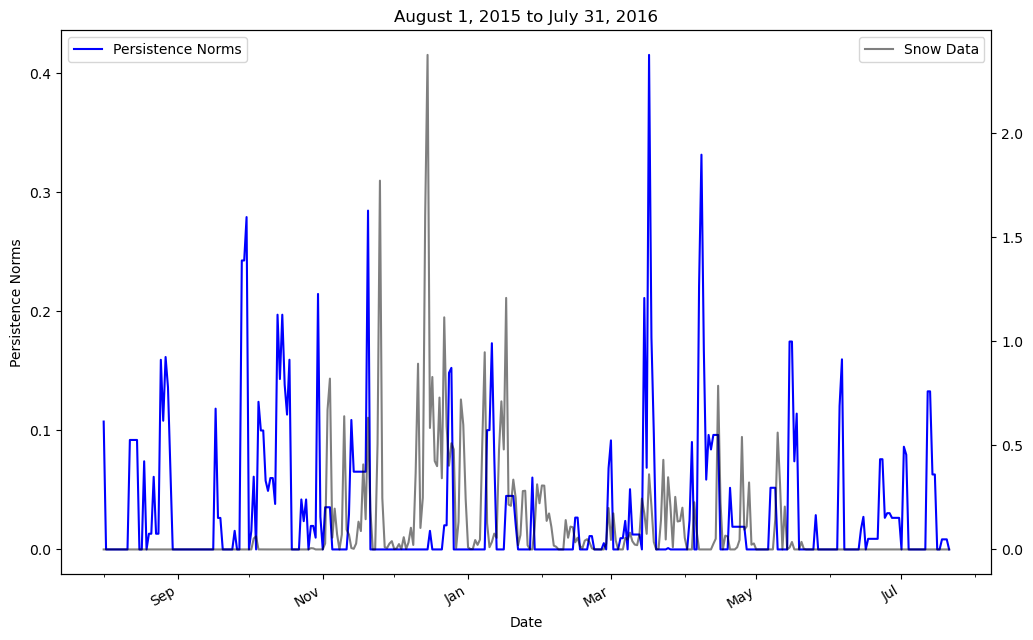

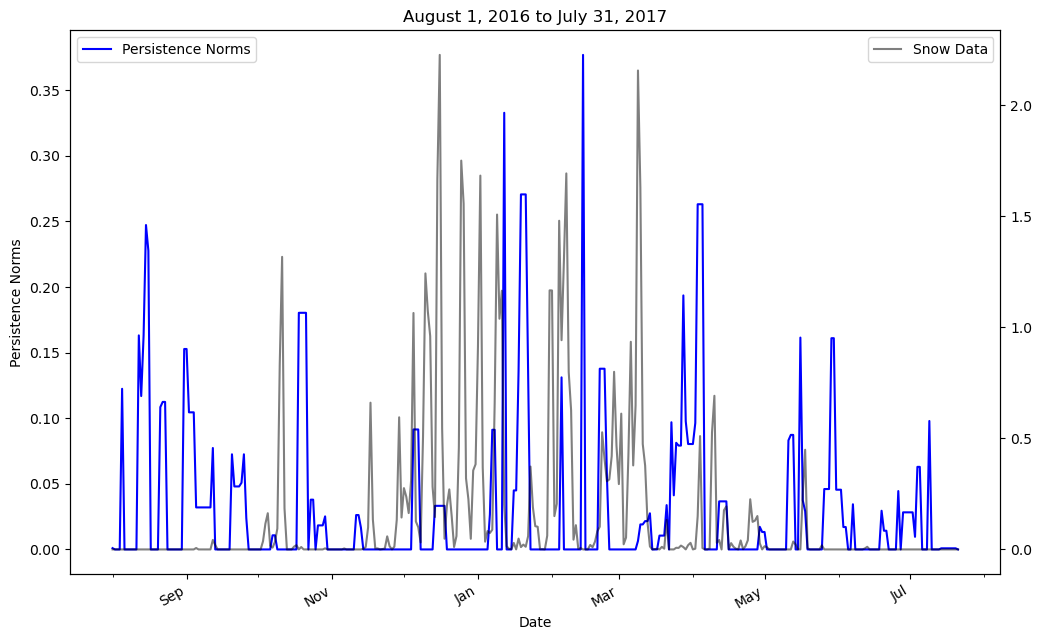

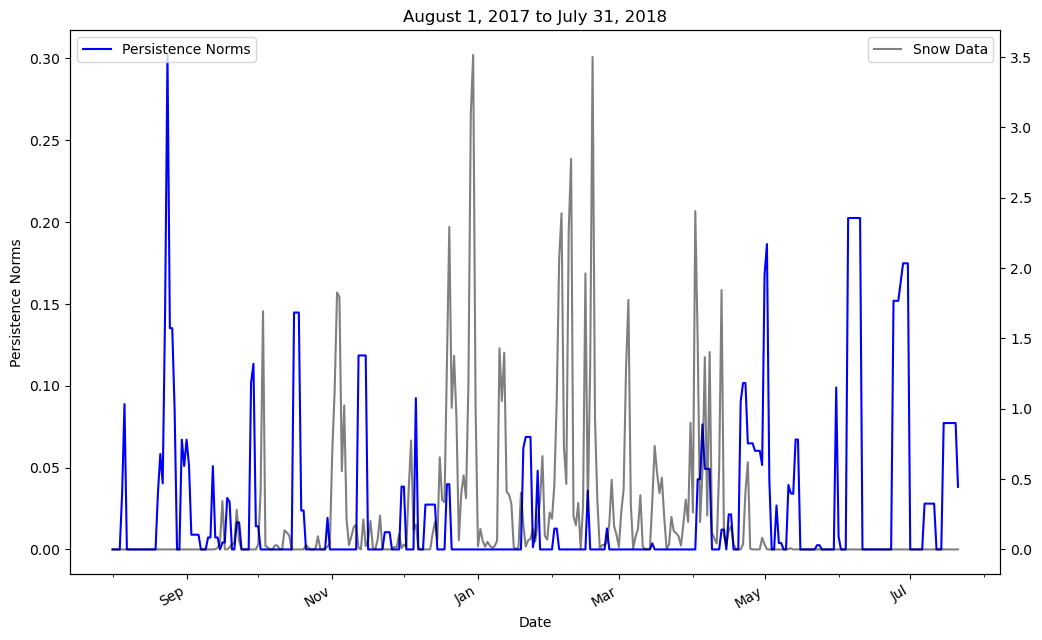

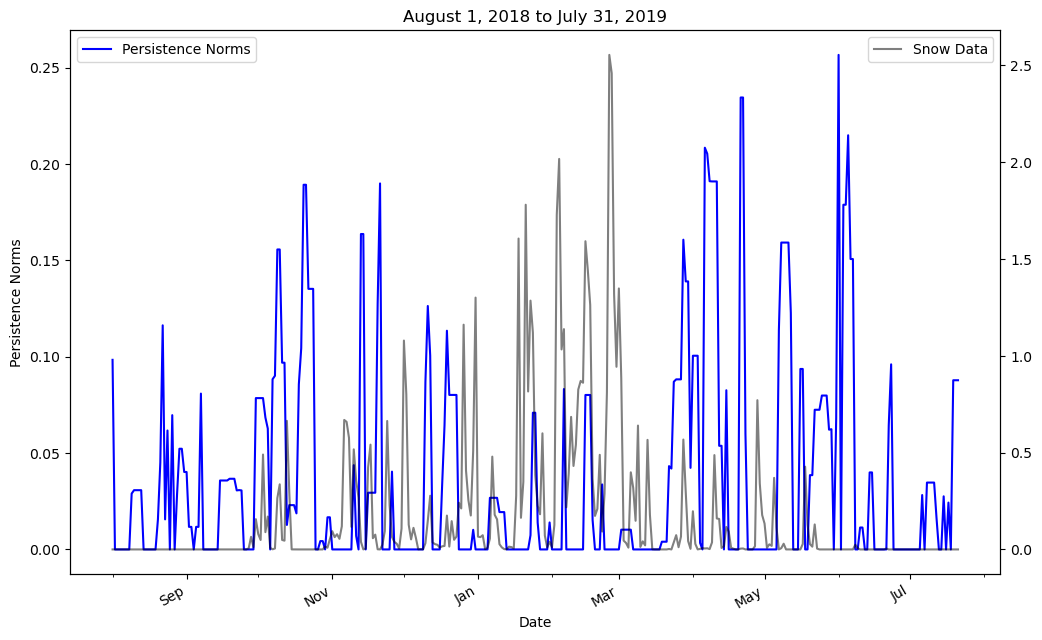

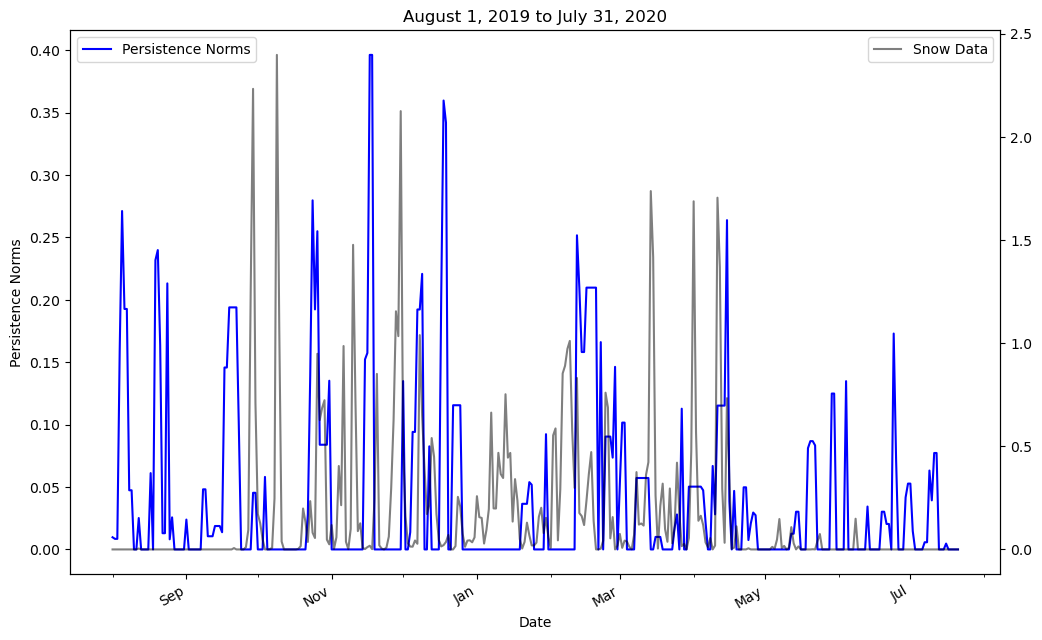

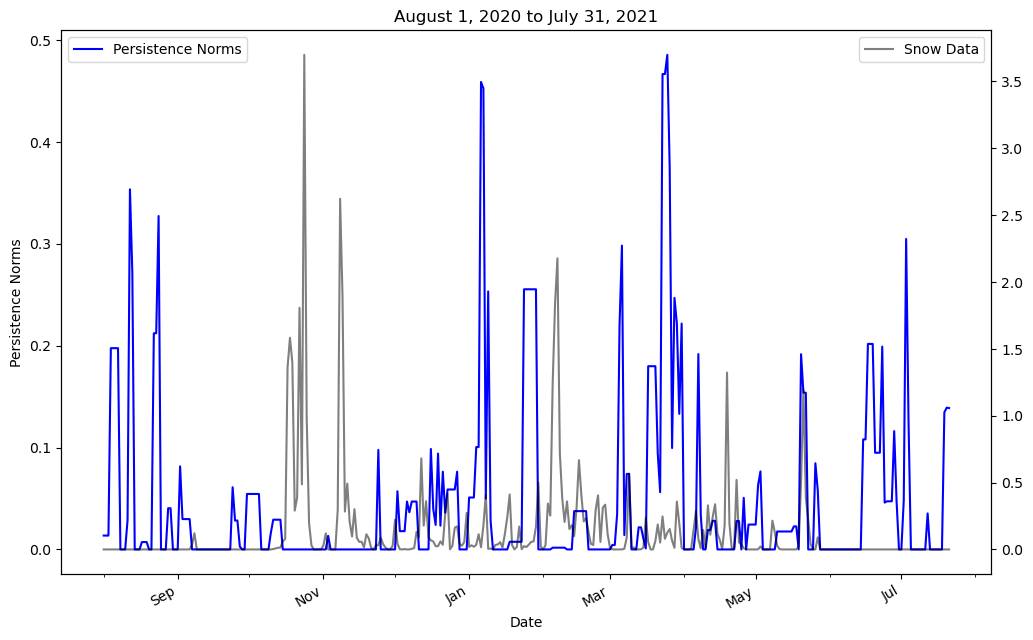

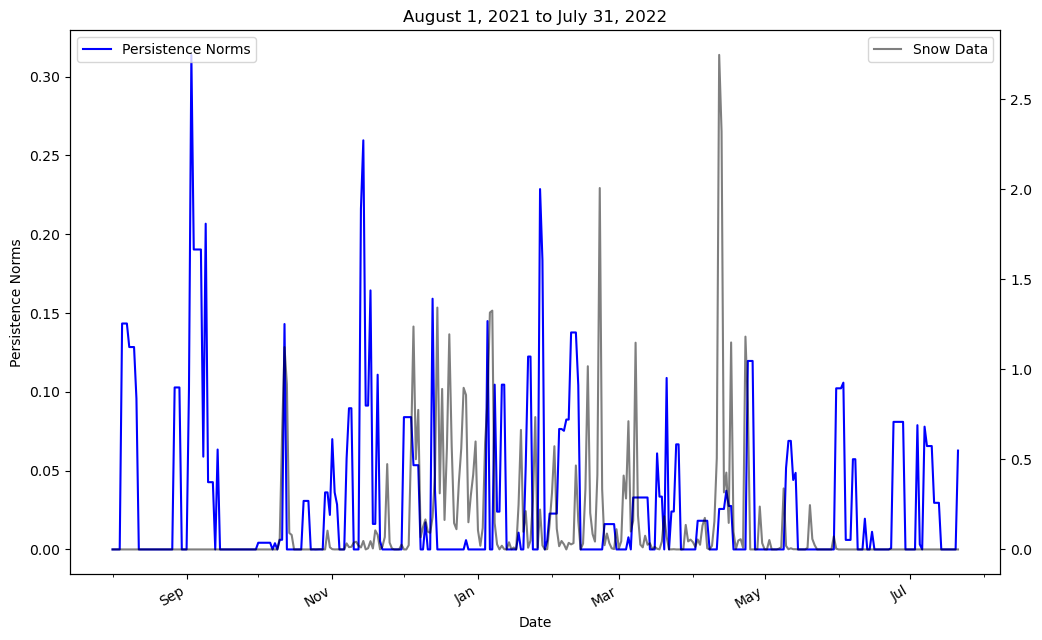

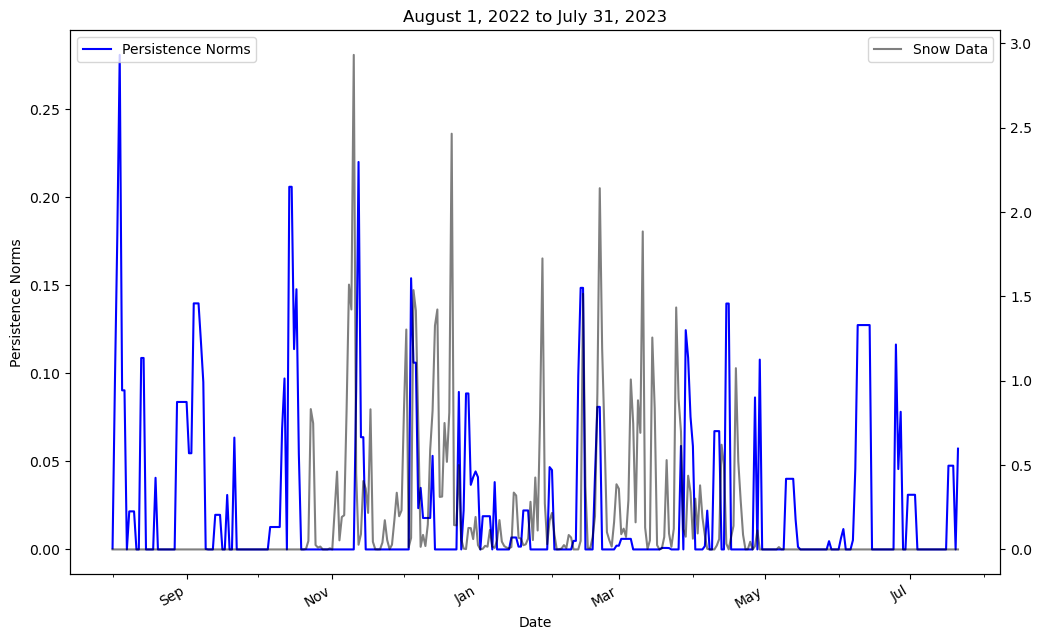

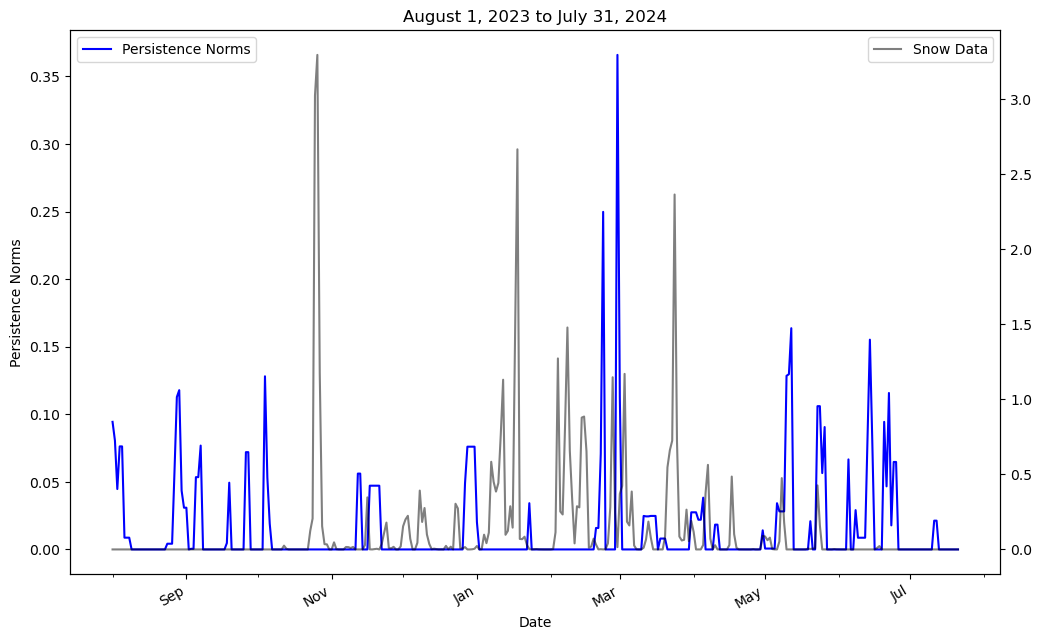

In [10]:
import numpy as np
import pandas as pd
import gudhi as gd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from gudhi.representations import Landscape
from sklearn.preprocessing import StandardScaler

# === CONFIGURATION ===
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021,2022,2023]
window_size = 10  # Window for sliding persistence computation

# === LOAD TIME SERIES DATA ===
# List all your separate time series DataFrames here (excluding snow data)
dataframes = [
    #pd.read_csv("timeseries/montana_tmax_timeseries.csv", parse_dates=["DATE"], index_col="DATE"),
    pd.read_csv("timeseries/montana_tmin_timeseries.csv", parse_dates=["DATE"], index_col="DATE"),
    #pd.read_csv("timeseries/montana_rhmn_timeseries.csv", parse_dates=["DATE"], index_col="DATE"),
    pd.read_csv("timeseries/montana_rhmx_timeseries.csv", parse_dates=["DATE"], index_col="DATE"),
    pd.read_csv("timeseries/montana_adpt_timeseries.csv", parse_dates=["DATE"], index_col="DATE")
    #pd.read_csv("timeseries/montana_aslp_timeseries.csv", parse_dates=["DATE"], index_col="DATE"),
    #pd.read_csv("timeseries/montana_astp_timeseries.csv", parse_dates=["DATE"], index_col="DATE"),
]

# Load snowfall data separately
snow_data = pd.read_csv("timeseries/montana_snow_timeseries.csv", parse_dates=["DATE"], index_col="DATE")

# Merge all climate variable DataFrames on the 'DATE' index
data = dataframes[0]  # Start with the first DataFrame
for df in dataframes[1:]:
    data = data.join(df, how="inner")  # Inner join ensures only matching dates

# Rename columns dynamically
data.columns = [f"var_{i}" for i in range(len(data.columns))]

# Merge snow data separately to ensure it aligns
data = data.join(snow_data, how="inner", rsuffix="_snow")

# === STANDARDIZATION ===
scaler = StandardScaler()
data.iloc[:, :-1] = scaler.fit_transform(data.iloc[:, :-1])  # Normalize all climate variables except snowfall

# === PROCESSING FOR EACH YEAR ===
for year in years:
    # Select data from August 1 of `year` to July 31 of `year+1`
    data1 = data.loc[f'{year}-08-01' : f'{year+1}-07-31']

    # Extract snow data for the same time range
    snow_series = data1.iloc[:, -1]  # Last column should be snow data

    # Create an array for persistence diagrams
    dgms = np.empty(len(data1) - window_size, dtype=object)

    # Sliding window approach
    for i in range(len(data1) - window_size):
        # Extract window of data (each row is now a 7-dimensional point)
        point_cloud = data1.iloc[i:i+window_size, :-1].values  # Exclude snow data

        # Compute persistence
        rc = gd.RipsComplex(points=point_cloud)
        st = rc.create_simplex_tree(max_dimension=2)
        st.persistence()
        dgm = st.persistence_intervals_in_dimension(1)  
        dgms[i] = dgm  

    # Compute landscape norms
    norms = np.zeros(dgms.shape[0])
    for i in range(dgms.shape[0]):
        if dgms[i] is not None and len(dgms[i]) > 0:
            l = Landscape(num_landscapes=2, resolution=10).fit_transform([dgms[i]])
            norms[i] = np.linalg.norm(l[0])

    # === PLOTTING ===
    month_locator = mdates.MonthLocator()
    fig, ax = plt.subplots(figsize=(12, 8))
    month_year_formatter = mdates.DateFormatter('%b')
    ax.xaxis.set_minor_locator(month_locator)
    ax.xaxis.set_major_formatter(month_year_formatter)
    
    # Plot persistence landscape norms
    ax.plot(data1.index[:-window_size], norms, label="Persistence Norms", color="b")

    ax.set_title(f'August 1, {year} to July 31, {year+1}')
    ax.set_ylabel("Persistence Norms")
    ax.set_xlabel("Date")

    # Overlay snow data for reference
    ax2 = ax.twinx()
    ax2.plot(data1.index[:-window_size], snow_series[:-window_size], c='k', alpha=0.5, label="Snow Data")

    fig.autofmt_xdate()
    ax.legend(loc="upper left")
    ax2.legend(loc="upper right")

    plt.savefig(f'output_{year}.pdf', dpi=300)
    plt.show() 
